# Analysis of Spread of PDAF Protest Sentiment on Twitter

## Executive Summary

## Introduction

## The Dataset

## Methods

In [354]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import json
import glob
import ast
import re

import networkx as nx
from itertools import combinations
from collections import Counter 
from datetime import datetime

In [2]:
# load data paths
paths = glob.glob("data/*")
paths

['data/new_tweets_mpm.json',
 'data/tweets_mpm_list_following.json',
 'data/unified_followers.json',
 'data/unified_following.json',
 'data/user_followers.json',
 'data/user_following.json']

In [3]:
## IMPLEMENT KEY DUPLICATE REMOVER DURING CLEANING?
## Dictionaries automatically remove duplicates

In [4]:
def read_dict_from_file(path):

    # open scraped file as string
    f = open(path).read()

    # convert scraped file from string to dictionary
    dic = ast.literal_eval(f)

    # return dictionary of file
    return dic

In [5]:
# REMOVE BELOW NON-Number/Alphabet characters
# DO THE SAME FOR THE TWITTER PANDAS DATAFRAME

In [6]:
def clean_dict(dirty_dict, name_type="screen_name"):

    # define new dictionary
    new_dict = {}

    # get keys from input dirty dict
    keys = dirty_dict.keys()

    for key in keys:

        # format is [{"full_name" : "XX", "screen_name" : "YY"}]
        value = dirty_dict[key]
        
        # pattern for cleaning
        pattern = re.compile("[\w]+")

        # clean full_names and make lower_case
        # get followers full_name per user
        full_names = ["".join(re.findall(pattern, d[name_type])).lower() for d in value]

#         # get followers screen name per user
#         screen_names = [d["screen_name"] for d in value]
    
        # clean keys
        new_key = "".join(re.findall(pattern, key)).lower()
        
        # make key: value pair using full_name per user
        new_dict[new_key] = full_names

    # return new_dict
    return new_dict

# Analysis

## Preparing Follower and Following Data

In [8]:
# load dirty followers dictionary
path = "data/user_followers.json"
dirty_followers = read_dict_from_file(path)

# load dirty following dictionary
path = "data/user_following.json"
dirty_following = read_dict_from_file(path)

In [9]:
# get clean followers, full_name
clean_followers = clean_dict(dirty_followers, "screen_name")

# get clean following, full_name
clean_following = clean_dict(dirty_following, "screen_name")

In [10]:
# function to combine (get union) dictionaries
def union_dict(a, b):
    # a is the bigger dataset we will update with b
    for k, v in a.items():
        # if key is in a and b, then just append to current data in a
        if k in b.keys():
            # get union of unique items (remove redundancy)
            a[k] = list(set(a[k] + b[k]))

    # append keys in b that are not in a
    for k, v in b.items():
        if k not in a.keys():
            a[k] = v

    return a

In [11]:
# Test
a = {"a":[1, 2, 5], "b":[2, 3, 4]}
b = {"a":[1, 2, 3, 4], "c":[8, 9]}
union_dict(a, b)

{'a': [1, 2, 3, 4, 5], 'b': [2, 3, 4], 'c': [8, 9]}

In [12]:
# convert following to followers format
# e.g. {"user_A": ["followed_user_1", "followed_user_2"]
# turn to: {"followed_user_1" : ["user_A], "followed_user_2": ["user_A"]}
# So network direction goes from user (followed) to follower

def swap_key_val(old_dic):

    # get keys of dictionary to swap
    keys = old_dic.keys()

    # convert keys to vals and vals to keys
    # initiate new dictioanary (swapped)
    new_dic = {}
    for key in keys:
        # swap value and key
        a = {val: [key] for val in old_dic[key]}
        # add to new_dic using union_dict function
        new_dic = union_dict(new_dic, a)
    return new_dic

In [13]:
# Test
a = {"follower_a":["a", "b"], "follower_b":["b", "c", "d"]}
b = swap_key_val(a)
b

{'a': ['follower_a'],
 'b': ['follower_a', 'follower_b'],
 'c': ['follower_b'],
 'd': ['follower_b']}

In [14]:
a = clean_followers.copy()
b = clean_following.copy()

# get followers data from following data
followers_from_following = swap_key_val(b)

# get union of followers data (scraped) and followers from following data
unified_followers = union_dict(a, followers_from_following)

In [15]:
# save unified_followers to json
with open('data/unified_followers.json', 'w') as f:
    json.dump(unified_followers, f)

In [16]:
# load saved file

In [17]:
# get unified following data
# get following data from followers data

a = clean_followers.copy()
b = clean_following.copy()

following_from_followers = swap_key_val(a)

# get union of followers data (scraped) and followers from following data
unified_following = union_dict(b, following_from_followers)

In [18]:
# load saved file

In [19]:
# save unified_following to json
with open('data/unified_following.json', 'w') as f:
    json.dump(unified_following, f)

In [20]:
# length of scraped following
len(clean_following)

5119

In [21]:
# length of unified following
len(unified_following)

119605

In [22]:
# num of all users:followers scraped
len(unified_followers.keys())

122923

In [23]:
# num in just clean_followers
len(clean_followers.keys())

3028

In [24]:
# num in user:followers from following data
len(followers_from_following.keys())

120512

## Making Followers Graph - Asymmetric

We generate a graph of all the nodes in the followers and following dataset.

In [25]:
# load Graph of followers
G = nx.from_dict_of_lists(unified_followers, create_using=nx.DiGraph())
len(G.nodes)

224943

### Basic Properties

In [26]:
# out_degrees
degs = [k for n, k in G.out_degree]
avg_deg = np.mean(degs)
min_deg = np.min(degs)
max_deg = np.max(degs)

vals = {"avg_degree":[avg_deg], "min_degree":[min_deg], "max_degree":[max_deg]}
pd.DataFrame.from_dict(vals).T

,0
avg_degree,1.489239
min_degree,0.000000
max_degree,1730.000000


In [27]:
# in_degrees
degs = [k for n, k in G.in_degree]
avg_deg = np.mean(degs)
min_deg = np.min(degs)
max_deg = np.max(degs)

vals = {"avg_degree":[avg_deg], "min_degree":[min_deg], "max_degree":[max_deg]}
pd.DataFrame.from_dict(vals).T

,0
avg_degree,1.489239
min_degree,0.000000
max_degree,2846.000000


In [28]:
# degrees
degs = [k for n, k in G.degree]
avg_deg = np.mean(degs)
min_deg = np.min(degs)
max_deg = np.max(degs)

vals = {"avg_degree":[avg_deg], "min_degree":[min_deg], "max_degree":[max_deg]}
pd.DataFrame.from_dict(vals).T

,0
avg_degree,2.978479
min_degree,0.000000
max_degree,3298.000000


In [29]:
# clustering

### Degree Distribution

Text(0.5,1,'Out degree distribution')

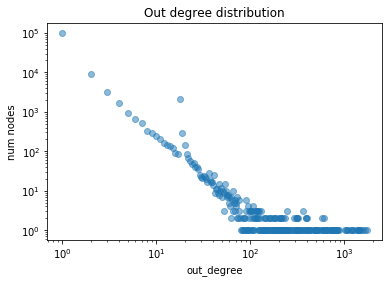

In [32]:
# out degree distribution
degs = [v for k, v in G.out_degree]

# count
deg_count = Counter(degs)

# plot
plt.loglog(deg_count.keys(), deg_count.values(), 'o', alpha=0.5)

plt.xlabel("out_degree")
plt.ylabel("num nodes")
plt.title("Out degree distribution")

Text(0.5,1,'In degree distribution')

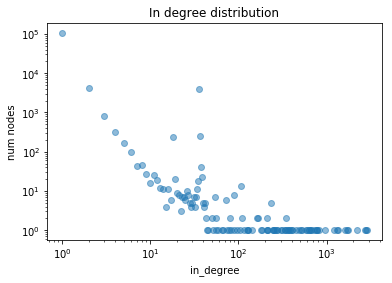

In [33]:
# in degree distribution
degs = [v for k, v in G.in_degree]

# count
deg_count = Counter(degs)

# plot
plt.loglog(deg_count.keys(), deg_count.values(), 'o', alpha=0.5)

plt.xlabel("in_degree")
plt.ylabel("num nodes")
plt.title("In degree distribution")

Text(0.5,1,'Degree distribution')

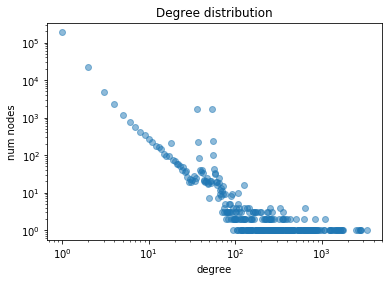

In [34]:
# degree distribution
degs = [v for k, v in G.degree]

# count
deg_count = Counter(degs)

# plot
plt.loglog(deg_count.keys(), deg_count.values(), 'o', alpha=0.5)

plt.xlabel("degree")
plt.ylabel("num nodes")
plt.title("Degree distribution")

In [ ]:
# VISUALIZATION
# # Use spring layout
# pos = nx.spring_layout(G)

# # draw graph
# plt.figure(figsize=(10, 10))
# nx.draw(G, pos=pos, node_size=2, with_labels=False)

## Filtering Followers Subgraph - Symmetric

The function below only selects that nodes that mutually follow each other (regardless if they tweeted about the protest or not). a <--> b will be preserved while c --> d will not be.

In [ ]:
# def filter_symmetric(matrix, nodes):
#     # get only symmetric
#     matrix_sym = np.multiply(matrix, matrix.T)
    
#     # make diagonal = 0
#     np.fill_diagonal(matrix_sym, 0)
    
#     # get indices with at least one degree in the symmetric network
#     nonzero = np.array(np.sum(matrix_sym, axis=0))
#     inds = list(np.nonzero(nonzero[0])[0])
    


#     # get nodes corresponding to index of nodes in symm network
#     sym_nodes = np.array(nodes)[inds]
    
#     return matrix_sym, sym_nodes

In [ ]:
# # TEST
# matrix = np.matrix([[1, 0, 1, 1], [1, 1, 0, 1], [1, 0, 0, 0], [0, 1, 1, 1]])
# nodes = ['a', 'b', 'c', 'd']
# filter_symmetric(matrix, nodes)

In [ ]:
# # make adjacency matrix
# matrix = nx.adjacency_matrix(G).todense()

# # get nodes list
# nodes = list(G.nodes)

# # THIS SHOULD BE EQUAL
# matrix.shape, len(nodes)

In [ ]:
# # CAN WE REMOVE THIS? SINCE THE IMPLEMENTATION BELOW WORKS AND THIS BREAKS
# # THIS KILLS THE KERNEL
# # filter symmetric adjacencty matrix
# sym_matrix, sym_nodes = filter_symmetric(matrix, nodes)

# print("No. of links in asymmetric network:", np.sum(matrix))
# print("Shape of asymmetric network:", matrix.shape)
# print("No. of links in symmetric network:", np.sum(sym_matrix)/2)
# print("Shape of symmetric network:", sym_matrix.shape, len(sym_nodes))

In [35]:
# Filter symmetric given dictionary of followers only
def filter_symmetric_from_dict(dic):
    # get dictionary of followers
    
    # define new dictionary    
    sym_dic = {}
    
    # run through keys and values
    for k, v in dic.items():
        # check if symmetric by looking at key and valu
        for i in v:
            try:
                if k in dic[i]:
                    if k in sym_dic:
                        sym_dic[k] += [i]
                    else:
                        sym_dic[k] = [i]
            except:
                continue
    return sym_dic

In [36]:
a = {'z':['e', 'b'], 'a':['b', 'c', 'd'], 'b':['a', 'z'], 'c':['a'], 'd':['c'], 'e':['z']}
filter_symmetric_from_dict(a)

{'a': ['b', 'c'], 'b': ['a', 'z'], 'c': ['a'], 'e': ['z'], 'z': ['e', 'b']}

In [37]:
# Filter the network for symmetric only 

# list of users in symmetric network
user_list = list(unified_followers.keys())

# filter only users in symmetric network
symm_followers = filter_symmetric_from_dict(unified_followers)

# make graph
H = nx.from_dict_of_lists(symm_followers, create_using=nx.DiGraph())

In [38]:
# Number of nodes in symmetric network
len(H.nodes)

12439

### Basic Properties

In [39]:
degs = [k for n, k in H.degree]
avg_deg = np.mean(degs)
min_deg = np.min(degs)
max_deg = np.max(degs)

vals = {"avg_degree":[avg_deg], "min_degree":[min_deg], "max_degree":[max_deg]}
pd.DataFrame.from_dict(vals).T

,0
avg_degree,3.510893
min_degree,2.000000
max_degree,1916.000000


### Degree Distribution

Text(0.5,1,'Degree distribution')

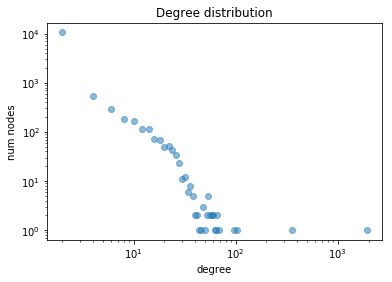

In [42]:
# degree distribution
degs = [v for k, v in H.degree]

# count
deg_count = Counter(degs)

# plot
plt.loglog(deg_count.keys(), deg_count.values(), 'o', alpha=0.5)

plt.xlabel("degree")
plt.ylabel("num nodes")
plt.title("Degree distribution")

In [ ]:
# VISUALIZATION
# # Use spring layout
# pos = nx.spring_layout(H)

# # draw graph
# plt.figure(figsize=(10, 10))
# nx.draw(H, pos=pos, node_size=2, with_labels=True, font_color='b', font_size=10)

## Fraction of Recruited Users Over Time (Nodes)


In [43]:
# get only nodes (following and followers) that are in a specific list
def filter_users_from_dic(followers_dic, user_list):
    # make dictionary of filtered keys
    filtered_dic = {k: followers_dic[k] for k in user_list}

    # filter values in dictionary - select only those in user_list
    for k, v in filtered_dic.items():
        filtered_dic[k] = [i for i in filtered_dic[k] if i in user_list]

    return filtered_dic

In [44]:
## CONSIDER RETWEETS - CURRENTLY CODE BELOW REMOVES RETWEETS DUE TO LACK OF DATE

In [45]:
# loading Tweets as dataframe
tweets_0 = pd.read_json("data/new_tweets_mpm.json")

# cleaning up user_screen_name
pattern = re.compile("[\w]+")
tweets_0.user_screen_name = tweets_0.user_screen_name.apply(
    lambda x: re.findall(pattern, "".join(re.findall(pattern, x)).lower())[0])

# remove specific duplicate case
tweets_0 = tweets_0.drop(index=2249)

# convert date to date time
tweets = tweets_0.copy()
tweets.date = pd.to_datetime(tweets_0.date)

# remove date outside 2013
tweets = tweets[(tweets['date'] > '2013-01-01 00:00:00')
                & (tweets['date'] < '2013-12-31 00:00:00')]

# sort values by date
tweets = tweets.sort_values(by="date")

# drop duplicates in case there are duplicates
tweets = tweets.drop_duplicates(keep="first")

# reset index
tweets = tweets.reset_index()

tweets.head()

,index,date,likes,parent_tweet_id,replies,reply,retweet,retweets,text,timestamp,tweet_id,user_id,user_name,user_screen_name
0,9754,2013-08-17 15:45:11,0,NaN,1,0,0,2,#millionpeoplemarch on august 26 luneta. This...,1376754311,3.687604e+17,32382474,yo de,xuyode
1,9755,2013-08-17 15:45:37,0,3.687604e+17,0,1,0,0,@sdoroquis,1376754337,3.687605e+17,32382474,yo de,xuyode
2,9751,2013-08-17 21:33:27,1,NaN,0,0,0,3,Maybe running + bike community wud want 2 know...,1376775207,3.688481e+17,470960342,running host,hostboyramos
3,9741,2013-08-18 01:13:49,4,NaN,1,0,0,9,"Napoles is just the visible ""fall guy"" of sort...",1376788429,3.689035e+17,24533024,"Rudy Villar, Jr.",rudyvillar
4,9742,2013-08-18 01:29:55,0,3.689035e+17,0,1,0,0,@larionedjames secrets that will soon be revea...,1376789395,3.689076e+17,24533024,"Rudy Villar, Jr.",rudyvillar


In [46]:
# length of dataframe
len(tweets_0)

9767

In [270]:
# length of tweets only
len(tweets_0[np.logical_and(tweets_0.reply == 0, tweets_0.retweet == 0)])

690

In [48]:
# number of retweets
len(tweets_0[tweets_0.retweet == 1])

7354

In [49]:
# number of replies
len(tweets_0[tweets_0.reply == 1])

1723

Text(0.5,1,'Fraction of recruited users over time')

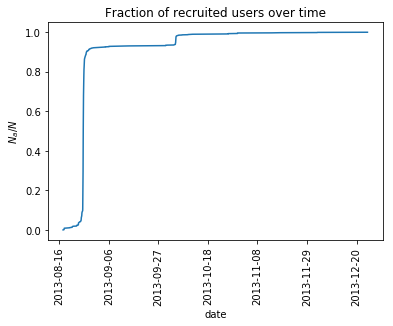

In [348]:
# get only the first time a unique user tweet/retweet or replies with relevant #hash
unique_users = tweets.drop_duplicates(subset="user_screen_name", keep="first")

# sort by date
unique_users = unique_users.sort_values(by="date")

# reset index
unique_users = unique_users.reset_index()

# get cumulative distribution, each user adds 1 to the count
count_cumulative = [i + 1 for i in range(len(unique_users))]
prop_cumulative = [i / len(unique_users) for i in range(len(unique_users))]

# plot the distribution
plt.plot(unique_users.date, prop_cumulative)
plt.xticks(rotation=90)
plt.xlabel("date")
plt.ylabel("$N_a/N$")
plt.title("Fraction of recruited users over time")

In [353]:
# get days with most frequent tweets
unique_users.date.dt.date.value_counts()[:10]

2013-08-26    962
2013-08-25    114
2013-10-04     59
2013-08-27     36
2013-08-24     22
2013-08-28     13
2013-08-18     10
2013-08-21      8
2013-08-23      7
2013-08-29      6
Name: date, dtype: int64

In [51]:
## DO THE SAME ABOVE FOR COMBINATIONS OF TWEETS, RETWEETS, and REPLIES

In [52]:
# number of unique users
# Excluding retweets
len(unique_users)

1288

In [53]:
# Add date column to tweets data (without time)
tweets['date'] = [tweets.date[i] for i in range(len(tweets))]

# Number of tweets and unique tweets and replies
# No retweets
print("No. of tweets/replies:", len(tweets))
print("No. of unique tweets/replies:", len(tweets.text.unique()))

# Add date to nodes data for filtering say of degrees?

No. of tweets/replies: 2116
No. of unique tweets/replies: 2081


In [54]:
# filter only those in unified_followers dataset
users_list = list(unified_followers.keys())
tweets_2 = tweets[tweets.user_screen_name.isin(
    users_list)].reset_index(drop=True)
tweets_2 = tweets_2.drop("index", axis=1)
tweets_2.head()

,date,likes,parent_tweet_id,replies,reply,retweet,retweets,text,timestamp,tweet_id,user_id,user_name,user_screen_name
0,2013-08-18 01:13:49,4,NaN,1,0,0,9,"Napoles is just the visible ""fall guy"" of sort...",1376788429,3.689035e+17,24533024,"Rudy Villar, Jr.",rudyvillar
1,2013-08-18 01:29:55,0,3.689035e+17,0,1,0,0,@larionedjames secrets that will soon be revea...,1376789395,3.689076e+17,24533024,"Rudy Villar, Jr.",rudyvillar
2,2013-08-18 01:32:43,0,NaN,1,0,0,5,Let's all go. I'm going. Are you? #porkbarrels...,1376789563,3.689083e+17,56945013,Angku,angkulet
3,2013-08-18 01:44:27,2,NaN,1,0,0,11,"""@DirekJoey: On the 26th of August, Luneta at ...",1376790267,3.689112e+17,332857235,Bee Yen,kamoterunner
4,2013-08-18 01:50:33,1,3.689112e+17,1,1,0,0,@bananarunning @pambansanglegs @brylleforonda ...,1376790633,3.689128e+17,332857235,Bee Yen,kamoterunner


In [55]:
# check for similar tweet_id values - there shouldn't be duplicates
# WE CAN REMOVE THIS
for i in range(len(tweets)):
    if len(tweets[tweets.tweet_id == tweets.tweet_id.values[i]]) > 1:
        display(tweets[tweets.tweet_id == tweets.tweet_id.values[i]])


In [56]:
# No. of filtered tweets and users
len(tweets_2), len(tweets_2.user_screen_name.unique())

(1541, 798)

## Filtering Only Users that Tweeted the #Hashtag and their Followers (who may or may not have tweeted the #Hashtag)

### Asymmetric Graph

In [57]:
# get list of unique user_screen_name in pandas dataframe
# this is the list that is both in the followers list and in the tweets data
# No yet concern for TIME so WE USE tweets_0
# tweets, replies, and retweets
final_users = list(tweets_0.user_screen_name.unique())
len(final_users)

6463

In [58]:
# filter user - follower dictionary to include only those selected above
# users_followers = {k: unified_followers[k] for k in final_users}
# Get the intersection of user:followers list and the tweets

# some users in the dataframe has not been scraped yet
users_followers = {}
for k in final_users:
    try: users_followers[k] = unified_followers[k]
    except: continue

# these are the keys only
len(users_followers)

3507

In [59]:
# make a network using the filtered users_followers above
# load Graph of followers
# includes nodes that may not have tweeted about the protest
G = nx.from_dict_of_lists(users_followers, create_using=nx.DiGraph())

# Use spring layout
# pos = nx.spring_layout(G)

len(G.nodes)

118749

#### Basic Properties

In [60]:
# out degree
degs = [k for n, k in G.out_degree]
avg_deg = np.mean(degs)
min_deg = np.min(degs)
max_deg = np.max(degs)

vals = {"avg_degree":[avg_deg], "min_degree":[min_deg], "max_degree":[max_deg]}
pd.DataFrame.from_dict(vals).T

,0
avg_degree,1.110502
min_degree,0.000000
max_degree,1730.000000


In [61]:
# in degree
degs = [k for n, k in G.in_degree]
avg_deg = np.mean(degs)
min_deg = np.min(degs)
max_deg = np.max(degs)

vals = {"avg_degree":[avg_deg], "min_degree":[min_deg], "max_degree":[max_deg]}
pd.DataFrame.from_dict(vals).T

,0
avg_degree,1.110502
min_degree,0.000000
max_degree,240.000000


In [62]:
# degree
degs = [k for n, k in G.degree]
avg_deg = np.mean(degs)
min_deg = np.min(degs)
max_deg = np.max(degs)

vals = {"avg_degree":[avg_deg], "min_degree":[min_deg], "max_degree":[max_deg]}
pd.DataFrame.from_dict(vals).T

,0
avg_degree,2.221004
min_degree,0.000000
max_degree,1788.000000


#### Degree Distribution

Text(0.5,1,'Out degree distribution')

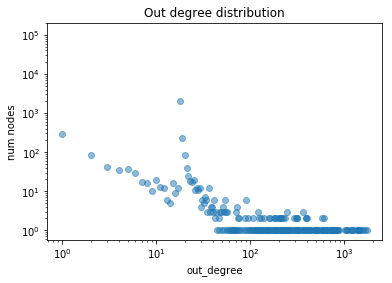

In [64]:
# out degree distribution
degs = [v for k, v in G.out_degree]

# count
deg_count = Counter(degs)

# plot
plt.loglog(deg_count.keys(), deg_count.values(), 'o', alpha=0.5)

plt.xlabel("out_degree")
plt.ylabel("num nodes")
plt.title("Out degree distribution")

Text(0.5,1,'In degree distribution')

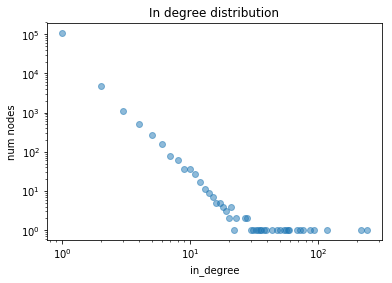

In [65]:
# in degree distribution
degs = [v for k, v in G.in_degree]

# count
deg_count = Counter(degs)

# plot
plt.loglog(deg_count.keys(), deg_count.values(), 'o', alpha=0.5)

plt.xlabel("in_degree")
plt.ylabel("num nodes")
plt.title("In degree distribution")

Text(0.5,1,'Degree distribution')

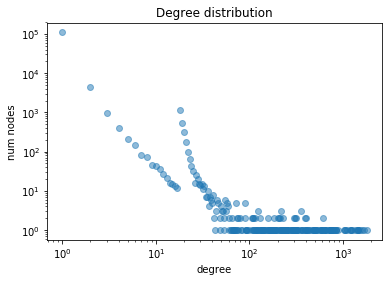

In [66]:
# degree distribution
degs = [v for k, v in G.degree]

# count
deg_count = Counter(degs)

# plot
plt.loglog(deg_count.keys(), deg_count.values(), 'o', alpha=0.5)

plt.xlabel("degree")
plt.ylabel("num nodes")
plt.title("Degree distribution")

In [ ]:
# # Use spring layout
# pos = nx.spring_layout(G)

# # draw graph
# plt.figure(figsize=(8, 8))
# nx.draw(G, pos=pos, node_size=2, with_labels=True)

### Symmetric Graph

In [67]:
# filter only symmetric
sym_users_followers = filter_symmetric_from_dict(users_followers)
len(sym_users_followers)

242

In [68]:
# load Graph of followers
H = nx.from_dict_of_lists(sym_users_followers)

#### Degree Distribution

Text(0.5,1,'Degree distribution')

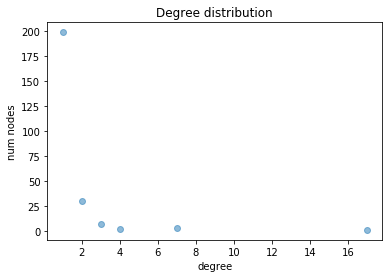

In [72]:
# degree distribution
degs = [v for k, v in H.degree]

# count
deg_count = Counter(degs)

# plot
plt.plot(deg_count.keys(), deg_count.values(), 'o', alpha=0.5)

plt.xlabel("degree")
plt.ylabel("num nodes")
plt.title("Degree distribution")

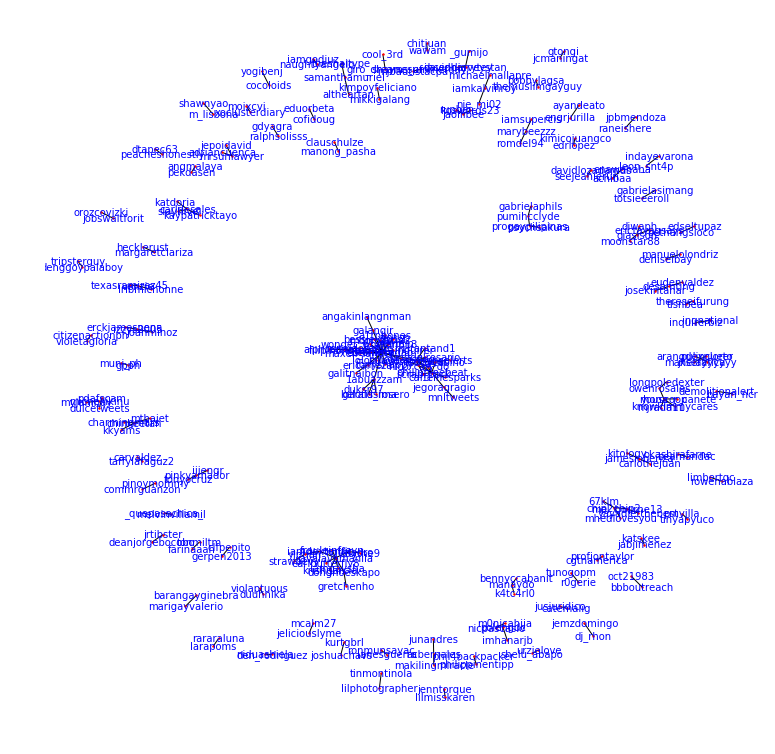

In [70]:
# Use spring layout
pos = nx.spring_layout(H)

# draw graph
plt.figure(figsize=(10, 10))

# draw graph
nx.draw(H, pos=pos, node_size=2, with_labels=True,
        font_color='b', font_size=10)

# WE CAN'T SCRAPE ALL, LOTS OF MISSING LINKS

In [88]:
# top degrees in symmetric networks
ind = np.argsort([v for k, v in H.degree])
np.array([k for k, v in H.degree])[ind][::-1][:5]

array(['berniecadao', 'philippinebeat', 'javalavamanila', 'momblogger',
       'youscoop'], dtype='<U15')

## Recruitment Thresholds Distribution

### Overall Threshold Distribution - Asymmetric

In [89]:
## WE DON'T HAVE DATE FOR RETWEETS. HOW CAN WE SOLVE THIS

In [156]:
def get_thresholds(following_counts, unique_users, following_dict):
    # input is a dictionary of {users : num of following}
    # input is unique users to select
    
    # initiate threshold dict
    thresh_dic = {}

    # Count the number of friends who activated at the time of activation, ka
    for user in list(following_counts.keys()):
        
        # check if user in user_screen_name in the dataset otherwise continue
        if user not in unique_users.user_screen_name.values:
            continue
        
        date_activated = unique_users[unique_users.user_screen_name == user].date

        # filter users whose date < date activated
        preactivated_users = unique_users[unique_users.date.values <
                                          date_activated.values]

        # filter only those being followed by user
        # DOUBLE CHECK THIS THIS SHOULDNT BE UNIFIED FOLLOWING
        _ = preactivated_users[preactivated_users.user_screen_name.isin(
            following_dict[user])]

        # get number of preactivated users that are being followed
        ka = len(_)

        # get number of people followed
        k = following_counts[user]
        
        if ka > k:
            print(ka, k)
            print(user)
        
        # if no connections, remove
        if k == 0:
            continue

        # get threshold
        thresh = ka / k
        

        # append to dictionary
        thresh_dic[user] = thresh

    return thresh_dic

In [157]:
# get following counts
following_counts = {k: len(v) for k, v in unified_following.items()}

# unique_users are unfiltered. Symmetric
unique_users = tweets.drop_duplicates(subset="user_screen_name", keep="first")

# show some threshold values
thresholds = get_thresholds(following_counts, unique_users, unified_following)

# display
len(thresholds)

1077

In [158]:
# mean threshold
np.mean([v for k, v in thresholds.items()])

0.028447418912240032

Text(0.5,1,'Num nodes vs ka/k')

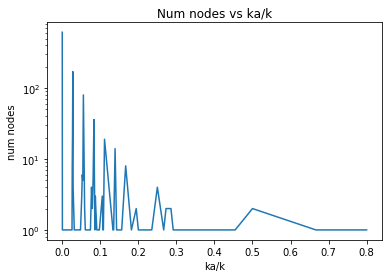

In [159]:
# plot distribution proportion of nodes vs ka/k
thresh = [v for k, v in thresholds.items()]
thresh_counts = Counter(thresh)
x = np.array(list(thresh_counts.keys()))
inds = np.argsort(x)
x_asym = x[inds]
y_asym = np.array(list(thresh_counts.values()))[inds]
plt.semilogy(x_asym, y_asym)
plt.xlabel("ka/k")
plt.ylabel("num nodes")
plt.title("Num nodes vs ka/k")

### Overall Threshold Distribution - Symmetric

In [160]:
# Filter the network for symmetric only
# list of users and who they follow in symmetric network
symm_following = filter_symmetric_from_dict(unified_following)

# make graph
H = nx.from_dict_of_lists(symm_following, create_using=nx.DiGraph())

len(H.nodes)

12439

In [162]:
# get following counts
following_counts = {k: len(v) for k, v in symm_following.items()}

# unique_users are unfiltered. Symmetric
unique_users = unique_users

# show some threshold values
thresholds = get_thresholds(following_counts, unique_users, symm_following)

len(thresholds)

384

In [163]:
# mean threshold
np.mean([v for k, v in thresholds.items()])

0.044529996388008454

Text(0.5,1,'Num nodes vs ka/k')

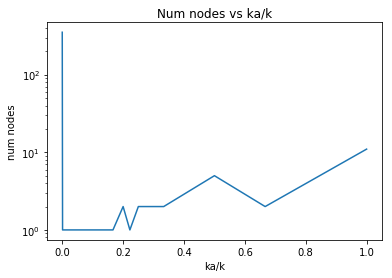

In [164]:
# plot distribution proportion of nodes vs ka/k
thresh = [v for k, v in thresholds.items()]
thresh_counts = Counter(thresh)
x = np.array(list(thresh_counts.keys()))
inds = np.argsort(x)
x_sym = x[inds]
y_sym = np.array(list(thresh_counts.values()))[inds]
plt.semilogy(x_sym, y_sym)
plt.xlabel("ka/k")
plt.ylabel("num nodes")
plt.title("Num nodes vs ka/k")

Text(0.5,1,'Num nodes vs ka/k')

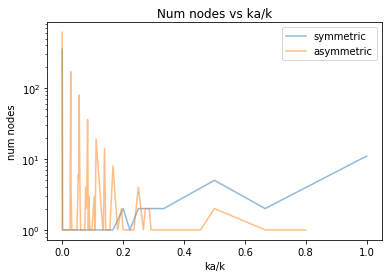

In [185]:
plt.semilogy(x_sym, y_sym, "-", alpha=0.5, ms=4, label="symmetric")
plt.semilogy(x_asym, y_asym, "-", alpha=0.5, ms=4, label="asymmetric")
plt.legend()
plt.xlabel("ka/k")
plt.ylabel("num nodes")
plt.title("Num nodes vs ka/k")

Assuming that retaining the symmetric network is like removing ifluencers and media (with huge number of followers but few users followed), or retaining groups of friends in the network, the threshold distribution shifts to higher threshold values. It might be that people in the symmetric subgraph needed more pressure to join the protest / be recruited. Media and influencers could have played a role in activating a significant portion of the users (lower required ka/k)

### Distribution of Low, Med, and High Threshold Users Over Time

In [388]:
# TO DO THIS!!!!
# ASYMMETRIC
# get following counts
following_counts = {k: len(v) for k, v in unified_following.items()}

# unique_users are unfiltered. Symmetric
unique_users = tweets.drop_duplicates(subset="user_screen_name", keep="first")

# show some threshold values
thresholds = get_thresholds(following_counts, unique_users, unified_following)

# display
len(thresholds)

1077

In [ ]:
thresholds

In [ ]:
# SYMMETRIC

### Threshold Distribution Before and After Protest

In [358]:
# threshold before protest
tweets_before = tweets_0[tweets_0.date < datetime(2013, 8, 26)].reset_index(drop=True)
len(tweets_before)

236

In [369]:
# get following counts
# asymmetric
following_counts = {k: len(v) for k, v in unified_following.items()}

# unique_users are unfiltered. Symmetric
unique_users = tweets_before.drop_duplicates(subset="user_screen_name", keep="first")

# show some threshold values
thresholds = get_thresholds(following_counts, unique_users, unified_following)

# display
len(thresholds)

74

In [370]:
# mean threshold
np.mean([v for k, v in thresholds.items()])

0.0034581423246540714

Text(0.5,1,'Num nodes vs ka/k')

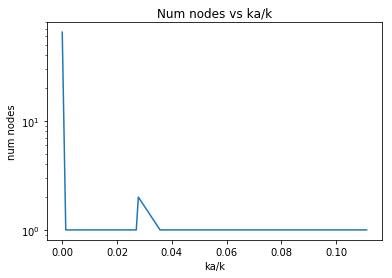

In [371]:
# plot distribution proportion of nodes vs ka/k
thresh = [v for k, v in thresholds.items()]
thresh_counts = Counter(thresh)
x = np.array(list(thresh_counts.keys()))
inds = np.argsort(x)
x_asym_before = x[inds]
y_asym_before = np.array(list(thresh_counts.values()))[inds]
plt.semilogy(x_asym_before, y_asym_before)
plt.xlabel("ka/k")
plt.ylabel("num nodes")
plt.title("Num nodes vs ka/k")

In [372]:
# threshold after protest
tweets_after = tweets_0[tweets_0.date >= datetime(2013, 8, 26)].reset_index(drop=True)
len(tweets_after)

2177

In [373]:
# get following counts
# asymmetric
following_counts = {k: len(v) for k, v in unified_following.items()}

# unique_users are unfiltered. Symmetric
unique_users = tweets_after.drop_duplicates(subset="user_screen_name", keep="first")

# show some threshold values
thresholds = get_thresholds(following_counts, unique_users, unified_following)

# display
len(thresholds)

1244

In [374]:
# mean threshold
np.mean([v for k, v in thresholds.items()])

0.013108244550533778

Text(0.5,1,'Num nodes vs ka/k')

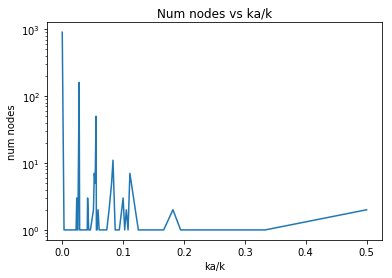

In [376]:
# plot distribution proportion of nodes vs ka/k
thresh = [v for k, v in thresholds.items()]
thresh_counts = Counter(thresh)
x = np.array(list(thresh_counts.keys()))
inds = np.argsort(x)
x_asym_after = x[inds]
y_asym_after = np.array(list(thresh_counts.values()))[inds]
plt.semilogy(x_asym_after, y_asym_after)
plt.xlabel("ka/k")
plt.ylabel("num nodes")
plt.title("Num nodes vs ka/k")

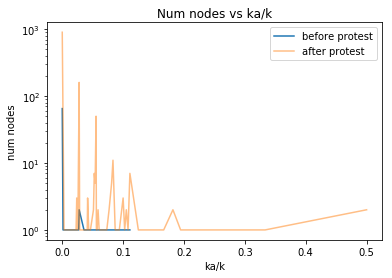

In [387]:
plt.semilogy(x_asym_before, y_asym_before, alpha=1, label="before protest")
plt.semilogy(x_asym_after, y_asym_after, alpha=0.5, label="after protest")
plt.xlabel("ka/k")
plt.ylabel("num nodes")
plt.title("Num nodes vs ka/k")
plt.legend()

## Recruitment Bursts

## Distribution of Cascade Size

In [ ]:
# How to identify cascade? retweet of same message?
    # Count how many retweeted same message = cascade size?
    # Count how many used the same #hashtag - cascade size?
    # Add k core attributes per node
    # Find K core of who started = seed/leader
    # Associate cascade size with k core of seed/leader

In [191]:
# count retweets for each parent id
cascade_sizes = tweets_0.groupby(
    by="parent_tweet_id").count().reset_index().iloc[:, :2].date.values

# Should we add this?
# # we add the original tweet
# cascade_sizes = cascade_sizes + 1

Text(0.5,1,'Distribution of cascade size')

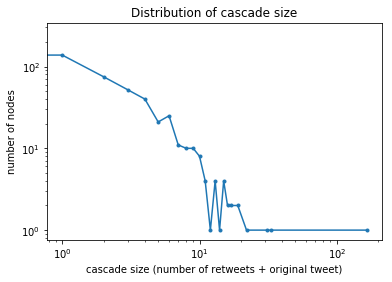

In [192]:
x = np.array(list(Counter(cascade_sizes).keys()))
inds = np.argsort(x)
x = x[inds]
y = np.array(list(Counter(cascade_sizes).values()))[inds]
plt.loglog(x, y, marker=".", )
plt.xlabel("cascade size (number of retweets + original tweet)")
plt.ylabel("number of nodes")
plt.title("Distribution of cascade size")

In [ ]:
# WE CAN CHECK WHO ARE THE NODES THAT REACHED MANY PEOPLE

## Node Centrality (K Core) vs Cascade Size

In [229]:
# make a dictionary of parent tweet_id and cascade size
# Check in the asymmetric network and symmetric network
# will associate parent_tweet_id with original tweeter and calculate k core

cascade_df = tweets_0.groupby(
    by="parent_tweet_id").count().reset_index().iloc[:, :2]
# rename column to cascade
cascade_df = cascade_df.rename(columns={"date": "cascade"})
cascade_df.head()

,parent_tweet_id,cascade
0,3.229498e+16,0
1,3.229898e+16,0
2,3.687604e+17,1
3,3.688481e+17,0
4,3.689035e+17,1


In [230]:
# k cores in asymmetric network
# from G above - includes followers who do not follow back and did not tweet
# about the protest
len(G.nodes)

118749

In [231]:
# remove self-loops
G.remove_edges_from(nx.selfloop_edges(G))

In [232]:
len(G.nodes)

118749

In [234]:
# k cores in asymmetric network - includes those who did not tweet about the protest
# {name: k_core, name: k_core}
k_cores_dict = nx.core_number(G)

# SAVE KCORE AS ATTRIBUTE OF NODE
len(k_cores_dict)

118749

In [236]:
# k_core per users
k_core_df = pd.DataFrame.from_dict(
    k_cores_dict, orient='index').reset_index()
len(k_core_df)

118749

In [278]:
# get the parent user screen name
cascade_df_2 = pd.merge(unique_users, cascade_df, left_on="tweet_id",
                        right_on="parent_tweet_id").loc[:, ["user_screen_name", "cascade"]]
cascade_df_2.head()

,user_screen_name,cascade
0,xuyode,1
1,hostboyramos,0
2,rudyvillar,1
3,angkulet,2
4,kamoterunner,2


In [280]:
k_core_users.head()

,index,0
0,ancalerts,9
1,berniecadao,9
2,sherylcayco,4
3,irneyespiritu1,7
4,tunogopm,6


In [294]:
# merge cascade size and kcore
df_cascade_kcore = pd.merge(k_core_users, cascade_df_2, left_on="index",
         right_on="user_screen_name")[[0, "cascade"]]
df_cascade_kcore.head()

,0,cascade
0,9,3
1,9,0
2,7,0
3,9,0
4,9,0


Text(0,0.5,'$N_c$/$N$')

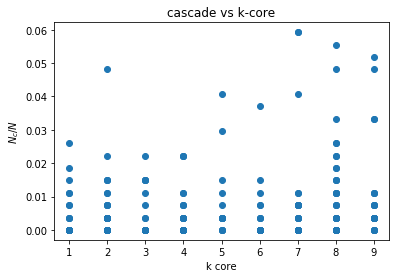

In [335]:
x = df_cascade_kcore[0]
inds = np.argsort(x)
x = x[inds]
y = df_cascade_kcore["cascade"][inds]

plt.plot(x, y/len(y), 'o')
plt.title("cascade vs k-core")
plt.xlabel("k core")
plt.ylabel("$N_c$/$N$")

Text(0,0.5,'Average cascade size')

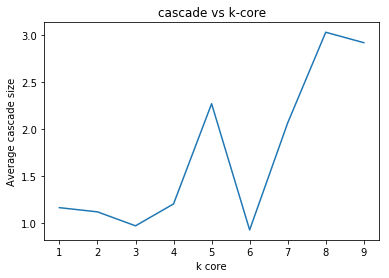

In [316]:
# average cascade size vs k core
cascade_kcore_mean = df_cascade_kcore.groupby(by=0).mean().reset_index()

x = cascade_kcore_mean[0]
inds = np.argsort(x)
x = x[inds]
y = cascade_kcore_mean["cascade"][inds]

plt.plot(x, y, '-')
plt.title("cascade vs k-core")
plt.xlabel("k core")
plt.ylabel("Average cascade size")

The average cascade size correlates positively with k core size. This may mean that tweets from users in higher k cores reach more people than users in lower k cores.

In [318]:
# correlate with kcore with degrees
# degree per users
degrees = dict(G.degree)

degree_df = pd.DataFrame.from_dict(
    degrees, orient='index').reset_index()



In [322]:
# merge cascade size and kcore
df_degree_k_core = pd.merge(degree_df, cascade_df_2, left_on="index",
         right_on="user_screen_name")[[0, "cascade"]]
df_degree_k_core.head()

,0,cascade
0,1788,3
1,278,0
2,55,0
3,130,0
4,246,0


Text(0,0.5,'cascade size')

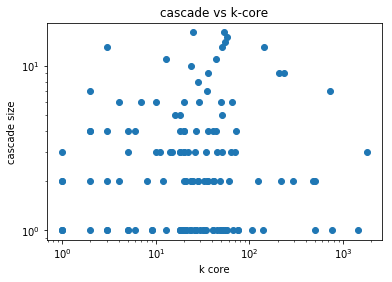

In [333]:
# degree vs k core

x = df_degree_k_core[0]
inds = np.argsort(x)
x = x[inds]
y = df_degree_k_core["cascade"][inds]

plt.loglog(x, y, 'o')
plt.title("cascade vs k-core")
plt.xlabel("k core")
plt.ylabel("cascade size")

Text(0,0.5,'Average cascade size')

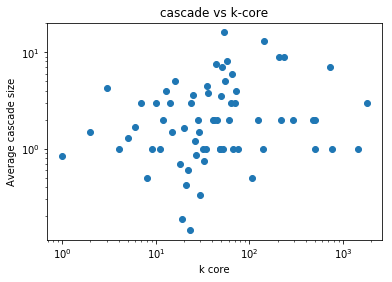

In [337]:
# mean degree vs k core
df_degree_k_core_mean = df_degree_k_core.groupby(by=0).mean().reset_index()

x = df_degree_k_core_mean[0]
inds = np.argsort(x)
x = x[inds]
y = df_degree_k_core_mean["cascade"][inds]

plt.loglog(x, y, 'o')
plt.title("cascade vs k-core")
plt.xlabel("k core")
plt.ylabel("Average cascade size")